####  **Initialise and load a pre-trained ResNet-18 model and move it to the GPU for faster processing.**



In [1]:
import torchvision.models as models

# Load the pre-trained ResNet-18 model and move it to the GPU
model = models.resnet18(pretrained=True).cuda()

model = model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 102MB/s]


In [2]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### **Initialise and preprocess the image by resizing, center cropping, converting it to a tensor, and normalizing it.**

In [4]:
# Import necessary modules for image transformations and handling
import torchvision.transforms as transforms
from PIL import Image

# Define normalization transform with mean and standard deviation values
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Define a transformation pipeline for preprocessing: resize and center crop
PIL_tops = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])

# Define a transformation pipeline for converting image to tensor and normalizing
tensor_tops = transforms.Compose([transforms.ToTensor(), normalize])

# Open an image file
img = Image.open("/content/input.jpg") # https://github.com/joe3141592/PyTorch-CAM/blob/master/input.jpg

# Apply the resizing and center cropping transformations
cropped_img = PIL_tops(img)

# Apply the tensor conversion and normalization transformations
trans_img = tensor_tops(cropped_img)

# Add a batch dimension and move the image tensor to the GPU
model_img = trans_img.unsqueeze(0).to("cuda")

print(model_img.shape) # torch.Size([1, 3, 224, 224])

torch.Size([1, 3, 224, 224])


#### **Initialise the hook the get the feature map of the last layer**

In [5]:
# Initialize an empty dictionary to store intermediate outputs
conv_data = {}

# Define a hook function to capture the output of the final feature map of the ResNet backbone
def __hook(module, inp, out):
    conv_data["output"] = out

# Register the first hook to the final feature map layer of the ResNet backbone (layer4)
model.layer4.register_forward_hook(__hook)


#### **CAM calculation**

In [116]:
# Get the output shape of the model after passing the transformed image through it
output_shape = model(trans_img.unsqueeze(0).to("cuda")).shape

# Extract the output of the convolutional layer
conv_layer_output = conv_data["output"]
conv_layer_output = conv_layer_output.squeeze(0)

# Retrieve the weights of the fully connected layer corresponding to the 'cat' class
fc_weights = model.fc.weight
cat_class_idx = 282  # Index of the 'cat' class in the ResNet-18 model
cat_fc_weights = fc_weights[cat_class_idx].unsqueeze(1).unsqueeze(1)

# Compute the weighted sum of the final convolutional layer
final_conv_layer_output = cat_fc_weights * conv_layer_output
class_activation_map = final_conv_layer_output.sum(0)

#### **CAM Visualization**

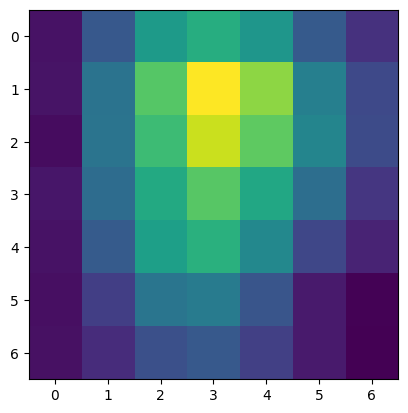

In [119]:
import matplotlib.pyplot as plt

plt.imshow(class_activation_map.to("cpu").detach().numpy())
plt.show()

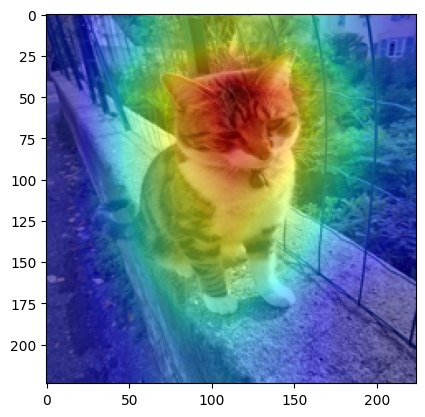

In [120]:
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Resize the CAM array to match the size of the original image tensor
cam_resized = F.interpolate(class_activation_map.unsqueeze(0).unsqueeze(0), size=tuple(model_img.shape[-2:]), mode='bilinear', align_corners=False)

# Convert the CAM tensor to a NumPy array
cam_np = cam_resized.squeeze().cpu().detach().numpy()
cam_expanded = np.expand_dims(cam_np, axis=2)

# Convert the original image tensor to a NumPy array
img_np = np.array(img.resize((224,224)))

# Display the overlaid image
plt.imshow(img_np)
plt.imshow(cam_expanded, alpha=0.5, cmap='jet')
plt.show()